# Bias versus Variance experiments with Ridge Regression

class 9
Mar 2024  JMA

In [106]:
import pandas as pd
import numpy as np
import os
# For vector norms, and determinants. 
import numpy.linalg as la
# Plotting
import matplotlib as plt
import seaborn as sns

from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, VBar, Span, Legend
from bokeh.io import output_notebook
from bokeh.palettes import Category10
output_notebook()

import sklearn.linear_model as sl
# use statsmodels to compute regression standard errors
# since scikit learn doesn't compute them.
import statsmodels.api as sm
# use to create the embeddings
# See  https://www.sbert.net/
from sentence_transformers import SentenceTransformer, util # use sbert's cosine similarity measure
EMBEDDING_DIMENSIONS = 384     # This model creates vectors of this length. 
# Principal component analysis
from sklearn.decomposition import PCA, TruncatedSVD
# The random number generator can be used to select a random set of columns for visualization
from numpy.random import Generator, PCG64
rng = Generator(PCG64())

Loading BokehJS ...

In [2]:
# Load the embedding vectors dataset 
if os.environ['HOME'] == '/Users/jma':
    featurized_parquet_file = '/Users/jma/Library/CloudStorage/OneDrive-Personal/' +\
    'teaching/sjsu/ISE201/ISE 201 - Math Foundations for Decision and Data Science/embeddings/' +\
    'sentence_embeddings.parquet'
else:
    featurized_parquet_file = 'data/sentence_embeddings.parquet'

text_df = pd.read_parquet(featurized_parquet_file)

# Extract the vector field and expand it to multiple rows. 
n_samples, embedding_dim = text_df.shape
data_ar = np.empty((n_samples, EMBEDDING_DIMENSIONS), 'float')
for i in range(n_samples):
    x = text_df.values[i,2]
    data_ar[i] = x 
    
data_ar[1:8,:]

array([[-0.00964857,  0.10622689,  0.04277224, ..., -0.163146  ,
        -0.05269159,  0.07252569],
       [-0.07081734,  0.0736165 ,  0.00798195, ..., -0.10635427,
        -0.00107698, -0.01324285],
       [-0.07396103,  0.06734046,  0.00833675, ...,  0.02894682,
        -0.02589605,  0.02248044],
       ...,
       [ 0.00305274, -0.06696875, -0.00200646, ...,  0.05169871,
         0.01019351,  0.01592024],
       [-0.09265527, -0.05914293, -0.03460407, ...,  0.05178332,
        -0.14583082,  0.0281018 ],
       [-0.08597914,  0.05730409, -0.08375977, ..., -0.03080781,
        -0.09040087,  0.01469508]])

In [3]:
text_df.head()

,review,sentiment,vector
0,So there is no way for me to plug it in here i...,0,"[0.08027008920907974, -0.04396028444170952, -0..."
1,"Good case, Excellent value.",1,"[-0.009648566134274006, 0.10622689127922058, 0..."
2,Great for the jawbone.,1,"[-0.07081733644008636, 0.07361650466918945, 0...."
3,Tied to charger for conversations lasting more...,0,"[-0.0739610344171524, 0.06734045594930649, 0.0..."
4,The mic is great.,1,"[-0.09819574654102325, 0.010798277333378792, 0..."


Text(0.5, 1.0, 'Error: 0.16')

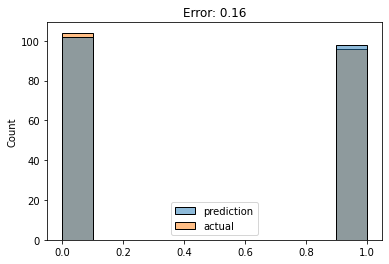

In [59]:
# Run a regularized linear regression
def ridge_regression(data_ar, sample_size = 200, learning_alpha=0.1):
    # Create a random sample, with replacement
    learning_set = np.random.choice(np.arange(len(data_ar)), sample_size, replace=False)
    learning_data = data_ar[learning_set,:]
    learning_outcome = text_df['sentiment'].values[learning_set]
    if learning_alpha == 0:
        regression_model = sl.LinearRegression()
    else:
        regression_model = sl.Ridge(alpha=learning_alpha)
    regression  =  regression_model.fit(learning_data, learning_outcome)

    # Run predictions against a hold-out set
    not_learning_set = set(text_df.index).difference(set(learning_set))
    holdout_set = np.random.choice(np.arange(len(not_learning_set)), sample_size, replace=False)

    test_threshold = 0.5
    predictions = regression.predict(data_ar[holdout_set,:])
    actuals = text_df['sentiment'].values[holdout_set]
    test_df = pd.DataFrame(dict(prediction=pd.Series(predictions >= test_threshold), actual=pd.Series(actuals)))
    test_error = sum(test_df.prediction != test_df.actual)/len(test_df)
    return test_error, test_df

test_error, test_df = ridge_regression(data_ar)
sns.histplot(test_df).set_title(f'Error: {test_error}')
 

# Ridge Regression Learning Curves

Ridge regression forces regression coefficients toward zero.  Why would one want to introduce bias to the regression coefficients?  These learning curves show that accuracy can increase for smaller datasets by trading off increased bias for decreased variance. 


In [77]:
# Show learning curves for different penalty values for the regression
alpha_range = [0, 0.1, 0.5,  0.9]# [0.01, 0.1, 0.5, 0.9, 0.95, 0.99]
log_range = [round(x) for x in log_range]
learning_curves = np.zeros([len(log_range), len(alpha_range)] )
for m, size in enumerate(log_range):
    for n, a in enumerate(alpha_range):
        learning_curves[m,n] = ridge_regression(data_ar, size, a)[0]
        # print(size, a, end=' ')
    # print()
df_learning_curves = pd.DataFrame(learning_curves, index=log_range, columns = [str(p) for p in alpha_range])
df_learning_curves.describe()


,0,0.1,0.5,0.9
count,50.000000,50.000000,50.000000,50.000000
mean,0.227471,0.194008,0.182168,0.185471
std,0.073592,0.071459,0.076735,0.100517
min,0.095238,0.083333,0.078498,0.083333
25%,0.173141,0.160926,0.132123,0.119886
50%,0.226378,0.180503,0.158863,0.145682
75%,0.265309,0.199383,0.211658,0.228224
max,0.428571,0.444444,0.400000,0.521739


In [101]:
# Smoothed learning curves
from scipy.ndimage import gaussian_filter1d

smoothed_lcurves = np.zeros(learning_curves.shape)
for col in range(learning_curves.shape[1]):
    smoothed_lcurves[:,col] = gaussian_filter1d(learning_curves[:,col], sigma=10)

df_smoothed_lcurves = pd.DataFrame(smoothed_lcurves, index=log_range, columns = [str(p) for p in alpha_range])
df_smoothed_lcurves.describe()

,0,0.1,0.5,0.9
count,50.000000,50.000000,50.000000,50.000000
mean,0.227471,0.194008,0.182168,0.185471
std,0.022968,0.017116,0.043125,0.050968
min,0.206475,0.170460,0.131916,0.123135
25%,0.207673,0.178274,0.143611,0.138990
50%,0.217277,0.192477,0.170036,0.173775
75%,0.244489,0.209609,0.219105,0.231271
max,0.272890,0.220680,0.258347,0.271115


In [93]:
raw_src.data.keys()

dict_keys(['level_0', 'index', '0', '0.1', '0.5', '0.9'])

In [110]:
# Plot learning curves for different ridge regressions. 

p = figure(width = 1000, height = 500, title = 'Ridge Regression Learning Curves')
p.xaxis.axis_label = 'Data Size'
p.yaxis.axis_label = 'Error rate'
raw_src = ColumnDataSource(df_learning_curves.reset_index())
smth_src = ColumnDataSource(df_smoothed_lcurves.reset_index())
# raw_src.data = {'size': log_range}
for n, a in enumerate(alpha_range):
    p.scatter(x='index', y=str(a), source=raw_src, color=Category10[5][n])
    p.line(x='index', y=str(a), source=smth_src, color=Category10[5][n], legend_label = str(a))
#lg = Legend(items= [str(p) for p in alpha_range], location = (100,0.4))
p.legend.title = "Penalty"
show(p)


<AxesSubplot:>

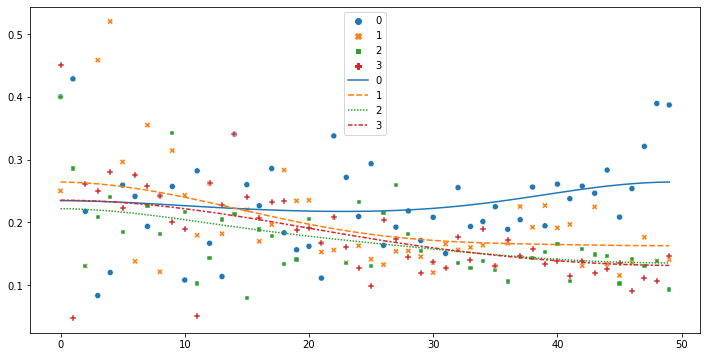

In [66]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(ncols=1, figsize = (12,6))
sns.scatterplot(learning_curves, ax=ax)
sns.lineplot(smoothed_lcurves)
